In [1]:
import hashlib 
import random
import math
import numpy as np
import math
import pandas as pd
from collections import Counter
inf = math.inf
def hex_id(id):
    return hashlib.md5(str(id).encode()).hexdigest()
def random_num(a,b):
    return a + random.random()*(b-a)


def power_m(M):
    return int(math.pow(2,M))

def in_range(item,id1,id2,M):
    #print("in range, ", item, id1, id2 )
    if id1 is None or id2 is None or item is None:
        return False
    item = item%int(power_m(M))
    id1 = id1%int(power_m(M))
    id2 = id2%int(power_m(M))
    if id1 == id2:
        return id1 == item
    if id1 < id2:
        return item >= id1 and item<= id2
    else:
        return item >= id1 or item <= id2

def get_prob_distribution(lst):
    
    a = Counter(lst)
    ct = sum(a.values())

    vals = list(a.keys())
    probs = [item*1.0/ct for item in a.values()]
    idx   = np.argsort(vals)
    vals = np.array(vals)[idx]
    probs = np.array(probs)[idx]
    return vals,probs

In [7]:
global id_to_node
id_to_node = {}

class Finger():
    def __init__(self,start=None,interval=None,node_id=None):
        self.start = start
        self.interval = interval
        self.node = node_id
        return
    
class Node():
    def __init__(self,id,M):
        self.id = id
        self.M = M
        self.finger = []
        self.data= {}
        for i in range(0,self.M):
            start = (id + int(math.pow(2,i)))%int(math.pow(2,self.M))
            end = (id + int(math.pow(2,i+1)))%int(math.pow(2,self.M))
            self.finger.append(Finger(start,(start,end)))
        self.successor = None
        self.predecessor = None
        
        
    def print_finger_table(self):
        print("Node id,", self.id)
        print("start         interval       successor")
        for i in range(0,self.M):
            print(self.finger[i].start, "    " ,self.finger[i].interval, "    ", self.finger[i].node)
        print("Predecesssor, ", self.predecessor)
        print("Successor, ", self.successor)
        print("###########################")
        return
            
    def find_successor(self,id,route=False):
        #if id == self.id:
            #return self.id
        if route:
            n_,route_ = self.find_predecessor(id,route)
            return id_to_node[n_].successor,route_ + [id_to_node[n_].successor]
        else:
            n_ = self.find_predecessor(id,route)
            return id_to_node[n_].successor
        #print("predecessor,", n_)
        
        
    def find_predecessor(self,id,route=False):
        n_ = self.id
        route_ = [n_]
        #print("find predecessor key, current node , successor ", id,n_,id_to_node[n_].successor)
        while not in_range(id,n_+1,id_to_node[n_].successor,self.M):
            #print("loop")
            n_ = id_to_node[n_].closest_preceding_finger(id)
            #print("closest preceding finger, ",n_)
            route_.append(n_)
        if route:
            return n_,route_
        else:
            return n_
    def closest_preceding_finger(self,id):
        for i in range(self.M-1,-1,-1):
            #print("in closest precedding, ", self.finger[i].node,self.id,id)
            if in_range(self.finger[i].node,self.id+1,id-1,self.M):
            #if in_range(id,self.finger[i].interval[0],self.finger[i].interval[1]-1,self.M):
                return self.finger[i].node
    
    def join(self,n_):
        if n_ not in id_to_node: ### that means it is first node to join###
            for i in range(0,self.M):
                self.finger[i].node = self.id
            self.predecessor = self.id
            self.successor = self.id
        else:    ### n_ exists
            #print("initializing")
            self.initialize_finger(n_)
            #print(id_to_node[n_].print_finger_table())
            #print("updating other nodes")
            self.update_other_nodes()
    def initialize_finger(self,n_):
        n_ = id_to_node[n_]
        #print(self.finger[0].interval)
        self.finger[0].node = n_.find_successor(self.finger[0].start)
        self.successor = self.finger[0].node
        self.predecessor = id_to_node[self.successor].predecessor
        id_to_node[self.successor].predecessor = self.id
        
        for i in range(1,self.M):
            self.finger[i].node = n_.find_successor(self.finger[i].start)
        
    def update_other_nodes(self):
        for i in range(0,self.M):
            if self.id-int(math.pow(2,i)) == self.predecessor:
                id_to_node[self.predecessor].update_finger_table(self.id,i)
            else:
                #print("key to find predecessor", self.id-int(math.pow(2,i)))
                p= self.find_predecessor(self.id-int(math.pow(2,i)))
                #print("in update other, ",p)
                id_to_node[p].update_finger_table(self.id,i)
    def update_finger_table(self,node,i):
        #print("here i , self, self.finger[i] node, self predec",i ,self.id,self.finger[i].node,self.predecessor)
        if self.id == node:
            return
        if in_range(node,self.id,self.finger[i].node-1,self.M):
            self.finger[i].node = node
            if i == 0:
                self.successor = node
            id_to_node[self.predecessor].update_finger_table(node,i)
        
            
    def add_key(self,key,value):
        n_ = self.find_successor(key)
        id_to_node[n_].add_key_to_itself(key,value)
        return
    def add_key_to_itself(self,key,value):
        self.data[key] = value
        return
    def return_val_for_key(self,key):
        if key in self.data:
            return self.data[key]
        return None
    def find_key(self,key):
        n_,route = self.find_successor(key,route = True)
        return (id_to_node[n_].return_val_for_key(key), route)
        #print(len(route))
        
    def update(self,delete_node,successor,predecessor):
        if self.successor == delete_node:
            self.successor = successor
        if self.predecessor == delete_node:
            self.predecessor = predecessor
            
        for finger in self.finger:
            if finger.node == delete_node:
                finger.node = successor
                
    def delete(self):
        successor = self.successor
        predecessor  = self.predecessor
        for node in id_to_node:
            if node != self.id:
                id_to_node[node].update(self.id,successor,predecessor)
        
        return
                
        
        

        
class Chord():
    def __init__(self,N):
        print("Adding nodes")
        self.seed = False
        M = 20
        #id_to_node = {}
        for i in range(0,N):
            id = random.choice(range(0,int(pow(2,M))))
            if i ==0:
                self.seed = id
            node = Node(id,M)
            id_to_node[id] = node
            if i == 0:
                node.join(0)
            else:
                node.join(self.seed)
        self.keys = []
    
        print("Adding keys")
        for i in range(0,10000):
            key = random.choice(range(0,int(pow(2,20))))
            self.keys.append(key)
            id_to_node[self.seed].add_key(key,str(key)+"_val")
    def find_key(self,key=None):
        if key is None:
            key = random.choice(self.keys)
        if self.seed in id_to_node:
            val,route = id_to_node[self.seed].find_key(key)
        else:
            val,route = id_to_node[list(id_to_node.keys())[0]].find_key(key)
        if route is not None:
            return len(route)
        else:
            return None
    def find_key_and_route(self):
        key = random.choice(self.keys)
        if self.seed in id_to_node:
            val,route = id_to_node[self.seed].find_key(key)
        else:
            val,route = id_to_node[list(id_to_node.keys())[0]].find_key(key)
        route = " -> ".join([str(item) for item in route])
        print("Lookup route of key,", str(key)," :",route)
    def delete_nodes(self,N):
        import random
        for i in range(0,N):
            node_id = random.choice(list(id_to_node.keys()))
            id_to_node[node_id].delete()
            del id_to_node[node_id]
    
    
#chord.delete_node(500)
# class Chord():
#     def __init__(self,N):
#         return
            
# node = Node(0,3)
# node.join(5) ### random number
# id_to_node[0] = node
# node1 = Node(1,3)
# id_to_node[1] = node1
# node1.join(0)
# # node1.print_finger_table()
# # node.print_finger_table()

# # print("successor, " ,node1.find_successor(3))
# # print("predecessor ", node.find_predecessor(0))
# node3 = Node(3,3)
# id_to_node[3] = node3
# node3.join(0)


# node6 = Node(6,3)
# id_to_node[6] = node6
# node6.join(1)
# print("### after joininng 6 ###")
# # node.print_finger_table()  
# # node1.print_finger_table()
# # node3.print_finger_table()
# # node6.print_finger_table()

# node3.find_successor(7,False)

In [8]:
chord = Chord(1000)

Adding nodes
Adding keys


In [12]:
id = random.choice(list(id_to_node.keys()))
print(id)
id_to_node[id].print_finger_table()

243877
Node id, 243877
start         interval       successor
243878      (243878, 243879)      245001
243879      (243879, 243881)      245001
243881      (243881, 243885)      245001
243885      (243885, 243893)      245001
243893      (243893, 243909)      245001
243909      (243909, 243941)      245001
243941      (243941, 244005)      245001
244005      (244005, 244133)      245001
244133      (244133, 244389)      245001
244389      (244389, 244901)      245001
244901      (244901, 245925)      245001
245925      (245925, 247973)      247058
247973      (247973, 252069)      248237
252069      (252069, 260261)      252412
260261      (260261, 276645)      261174
276645      (276645, 309413)      278058
309413      (309413, 374949)      311010
374949      (374949, 506021)      375505
506021      (506021, 768165)      508393
768165      (768165, 243877)      769352
Predecesssor,  243070
Successor,  245001
###########################


Creating network for  100
Adding nodes
Adding keys
Searching,
deleting 50% nodes
searching for queries
Creating network for  500
Adding nodes
Adding keys
Searching,
deleting 50% nodes
searching for queries
Creating network for  1000
Adding nodes
Adding keys
Searching,
deleting 50% nodes
searching for queries


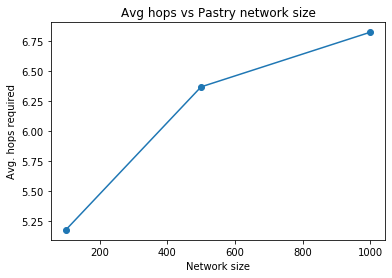

In [101]:
num_of_nodes = [100,500,1000]
hops_per_nodes = []
for nodes in num_of_nodes:
    print("Creating network for ", nodes)
    chord = Chord(nodes)
    hops_needed = []
    print("Searching,")
    for i in range(0,1000000):
        key = random.choice(chord.keys)
        hops = chord.find_key(key)
        if hops is not None:
            hops_needed.append(hops)
    hops_per_nodes.append(np.mean(hops_needed))
    vals,probs = get_prob_distribution(hops_needed)
    plt.clf()
    plt.bar(vals, probs,width=0.3)
    #plt.hist(hops_needed) # density
    plt.ylabel('Probability')
    plt.xlabel('Number of hops')
    plt.title("Distribution of hops required for 1 million queries in "+str(nodes) +" size network")
    plt.savefig(str(nodes)+"_chord_search_queries.svg")
    print("deleting 50% nodes")
    chord.delete_nodes(int(nodes*.5))
    print("searching for queries")
    for i in range(0,1000000):
        key = random.choice(chord.keys)
        hops = chord.find_key(key)
        if hops is not None:
            hops_needed.append(hops)
    vals,probs = get_prob_distribution(hops_needed)
    plt.clf()
    plt.bar(vals, probs,width=0.3)
    #plt.hist(hops_needed) # density
    plt.ylabel('Probability')
    plt.xlabel('Number of hops')
    plt.title("Distribution of hops required for 1 million queries after deletion")
    plt.savefig(str(nodes)+"_chord_delete_search_queries.svg")
    
plt.clf()
plt.plot(num_of_nodes, hops_per_nodes,'o-')
#plt.hist(hops_needed) # density
plt.ylabel('Avg. hops required')
plt.xlabel('Network size')
plt.title("Avg hops vs Pastry network size")
plt.savefig("chord_avg_hops_needed.svg")


In [88]:
for i in range(0,10):
    chord.find_key_and_route()
    print()
id_to_node[list(id_to_node.keys())[0]].print_finger_table()

Lookup route of key, 443636  : 339802 -> 406612 -> 439539 -> 443008 -> 443620 -> 445408

Lookup route of key, 793980  : 339802 -> 604542 -> 737729 -> 773200 -> 789882 -> 793125 -> 794210

Lookup route of key, 581388  : 339802 -> 473113 -> 541369 -> 574480 -> 579174 -> 581268 -> 581785

Lookup route of key, 677453  : 339802 -> 604542 -> 670131 -> 675207 -> 676548 -> 677094 -> 678426

Lookup route of key, 312023  : 339802 -> 864870 -> 80052 -> 211957 -> 279246 -> 297321 -> 306900 -> 311378 -> 312498

Lookup route of key, 492485  : 339802 -> 473113 -> 490930 -> 492425 -> 492964

Lookup route of key, 1001091  : 339802 -> 864870 -> 995976 -> 1000543 -> 1008914

Lookup route of key, 915454  : 339802 -> 864870 -> 897943 -> 906407 -> 910892 -> 913026 -> 913952 -> 918690

Lookup route of key, 189274  : 339802 -> 864870 -> 80052 -> 148233 -> 181162 -> 185383 -> 187565 -> 188668 -> 189191 -> 190928

Lookup route of key, 632042  : 339802 -> 604542 -> 623331 -> 632006 -> 632873



In [103]:
math.log(100,2)

6.643856189774725